# Importação das bibliotecas

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

## Variaveis e caminhos

In [2]:
idImagem = "1"

IMAGEM_CAPTURADA_SEGMENTADA = "caixas"            + idImagem + ".jpg"
IMAGEM_CAPTURADA_NORMAL =     "normal"            + idImagem + ".jpg"
IMAGEM_CORTADA_PEDUNCULO =    "pedunculoCortado"  + idImagem + ".png"
PEDUNCULO_HSV =               "pedunculoHSV"      + idImagem + ".png"
PEDUNCULO_BGR =               "pedunculoBGR"      + idImagem + ".png"

### Mostra imagem

In [3]:
def mostraImagem(imagemUso, titulo):

    fig = plt.figure(figsize = (5, 8))
    plt.title(titulo)
    plt.imshow(imagemUso)
    plt.show()

# Imagem Pré-Processada

Encontra a região de corte - trabalha apenas com a fruta

In [4]:
imgPreProcessada = cv.imread(IMAGEM_CAPTURADA_SEGMENTADA) #Leitura da imagem de entrada, imagem deve ser pré-processada - Real Time Object Detection
gray = cv.cvtColor(imgPreProcessada, cv.COLOR_BGR2GRAY) #Converte a imagem para tons de cinza

In [5]:
todas_coordenadas = [] #Guarda as coordenadas do eixo X e Y vindas dos cantos encontrados

cornersPedunculo = cv.goodFeaturesToTrack(gray, 4, 0.6, 0.2) #Função responsavel por encontrar os cantos Harrys

for item in cornersPedunculo:
    
    x,y = item[0]
    
    todas_coordenadas.append([x,y])
    #cv.circle(imgPreProcessada, (int(x),int(y)), 4, (0,0,255))
    
#mostraImagem(imgPreProcessada, "CAIXA SEGMENTADA")

In [6]:
todas_coordenadas.sort() #Ordena as coordenadas em ordem crescente


#Ultiza-se apenas a primeira coordenada e a ultima
xt = todas_coordenadas[0][0]
yt = todas_coordenadas[0][1]

xb = todas_coordenadas[3][0]
yb = todas_coordenadas[3][1]

#print(xt, yt)
#print(xb, yb)


In [7]:
#Regiao de interesse

Lmax = abs(xt - xb)
Hmax = abs(yt - yb)

RoiL = 0.5 * Lmax
RoiH = 0.5 * Hmax

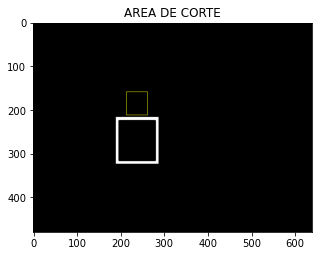

In [8]:
#Area de corte da imagem

#Esses coordenadas são as que vão delimitar a area onde a imagem vai ser cortada

centro = (xb + xt) / 2

centroCaixa = RoiL / 2

x1 = centro - centroCaixa
x2 = centro + centroCaixa

y1 = abs(yt - 5)
y2 = abs(RoiH - y1)

x1 = int(x1)
y1 = int(y1)
x2 = int(x2)
y2 = int(y2)

TopLeftY = y2
TopLeftX = x1

cv.rectangle(imgPreProcessada, (x2, y2), (x1,y1), (255,255,0), 1)

mostraImagem(imgPreProcessada, "AREA DE CORTE")


# Imagem Sem Processamento

Corte

In [9]:
img = cv.imread(IMAGEM_CAPTURADA_NORMAL) #Leitura da imagem de entrada, imagem deve ser sem processamento - Real Time Object Detection

In [10]:
crop = img[y2:y1, x1:x2] #Realiza o corte da imagem
cv.imwrite(IMAGEM_CORTADA_PEDUNCULO, crop) #Salva a imagem cortada

True

## Segmentação do pedúnculo

Primeira Segementação - HSV

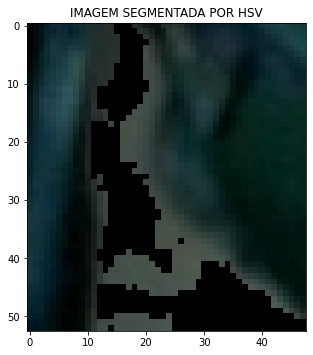

In [11]:
baixo = np.array([0, 30, 0])
alto = np.array([179, 255, 255])

imgPedunculo = [IMAGEM_CORTADA_PEDUNCULO]

for pedunculo in imgPedunculo:
    
    img = cv.imread(pedunculo)
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask = cv.inRange(img_hsv, baixo, alto)
    
    img_seg = cv.bitwise_and(img, img, mask = mask)
    
cv.imwrite(PEDUNCULO_HSV, img_seg)
    
mostraImagem(img_seg, "IMAGEM SEGMENTADA POR HSV")

Segunda Segmentação - BGR

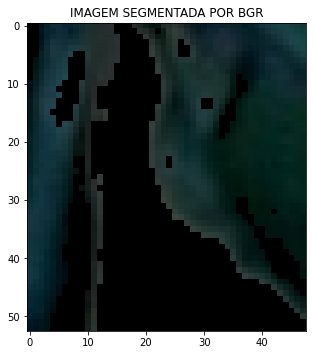

In [12]:
imgHSV = cv.imread(PEDUNCULO_HSV)

largura = imgHSV.shape[1]
altura  = imgHSV.shape[0]

imgBGR = cv.resize(imgHSV, (largura, altura))

height, width, canalCor = imgBGR.shape

base = [20,20,15]
fraca = [35,55,60]
forte = [70, 70, 100]
preto = [0, 0, 0]

for x in range(0, width):

    for y in range(0, height):

        canalXY = imgBGR[y,x]

        if all(canalXY <= base):

            imgBGR[y,x] = preto

        elif all(canalXY > fraca):

            imgBGR[y,x] = preto


cv.imwrite(PEDUNCULO_BGR, imgBGR)

mostraImagem(imgBGR, "IMAGEM SEGMENTADA POR BGR")
#print(largura, altura)

## Encontra ponto - trabalhar apenas com o pedúnculo

In [13]:
imgSegBGR = cv.imread(PEDUNCULO_BGR) #Leitura da imagem de entrada, imagem encontrada anteriormente - imagem cortada
gray = cv.cvtColor(imgSegBGR, cv.COLOR_BGR2GRAY) #Converte a imagem para tons de cinza

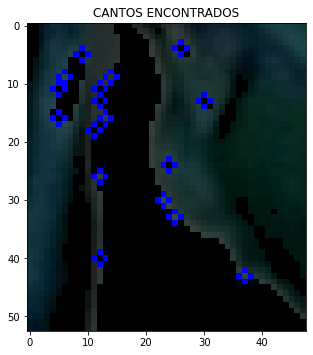

In [14]:
todas_coordenadas = [] 
todas_coordenadasX = [] #Guarda as coordenadas do eixo X vindas dos cantos encontrados
todas_coordenadasY = [] #Guarda as coordenadas do eixo Y vindas dos cantos encontrados

cornersPonto = cv.goodFeaturesToTrack(gray, 20, 0.2, 0.25) #Função responsavel por encontrar os cantos Harrys

for item in cornersPonto:
    
    x,y = item[0]
    
    todas_coordenadas.append((x,y))
    todas_coordenadasX.append(int(x))
    todas_coordenadasY.append(int(y))
    cv.circle(imgSegBGR, (int(x),int(y)), 1, (0,0,255))
    
mostraImagem(imgSegBGR, "CANTOS ENCONTRADOS")

In [15]:
#print(todas_coordenadasX)
#print(todas_coordenadasY)
#print(todas_coordenadas)

## Função encontra ponto de partida

In [16]:
#Funções

#Calcula o peso das coordenadas

def calculaPesoY(a):
    
    calPeso = (a[0] * a[0]) + (a[1] * a[1])
    
    calPeso = np.sqrt(calPeso)
    
    calPeso = int(calPeso)
    
    return calPeso

def calculaPesoX(a, centro):
    
    if(a[0] < centro):
        
        dif = (centro - a[0])
        
        soma = a[0] + dif
        
    else:
        
        soma = a[0]
        
    calPeso = (soma * soma) + (a[1] * a[1])
    
    calPeso = np.sqrt(calPeso)
    
    calPeso = int(calPeso)
    
    return calPeso



#Faz a combinação entre a coordenadas e os pesos

def combinacao(peso: list, todas_coordenadasN: list) -> list:
    
    assert len(peso) == len(todas_coordenadasN)
 
    n = len(peso)
    
    combi = []
 
    for i in range(n):
        
        combi.append((peso[i], todas_coordenadasN[i]))
 
    return combi

#Calcula a media dos pontos

def calculaMedia(m):
    
    calMedia = (m[0] * m[1])
    
    calMedia = int(calMedia)
    
    return calMedia

In [17]:
pesoY = []
pesoX = []
mediaX = []
mediaY = []
centro = imgBGR.shape[0] / 2

centro = int(centro)

#Calcula o peso de Y
for i in todas_coordenadas:
    
    aux = calculaPesoY(i)
    
    pesoY.append(aux)
    
#Calcula o peso de X
for i in todas_coordenadas:
    
    aux = calculaPesoX(i, centro)
    
    pesoX.append(aux)
    
#Somatorio do peso Y
somatorioPesoY = sum(pesoY)

#Somatoria do pedo X
somatorioPesoX = sum(pesoX)
    
#Realiza combinação
combinacaoX = combinacao(pesoX, todas_coordenadasX)
combinacaoY = combinacao(pesoY, todas_coordenadasY)

#Calcula a media dos pontos X
for i in combinacaoX:
    
    aux = calculaMedia(i)
    
    mediaX.append(aux)
    
#Calcula a media dos pontos Y
for i in combinacaoY:
    
    aux = calculaMedia(i)
    
    mediaY.append(aux)


somatorioX =  sum(mediaX)
somatorioY =  sum(mediaY)

pontoX = (somatorioX / somatorioPesoX)  
pontoY = (somatorioY / somatorioPesoY)

pontoX = int(pontoX)
pontoY = int(pontoY)

print(pontoX, pontoY)

17 23


In [18]:
#pontoX = np.mean(todas_coordenadasX)
#pontoY = np.mean(todas_coordenadasY)
#pontoX = int(pontoX)
#pontoY = int(pontoY)

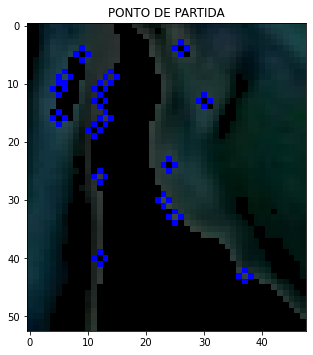

In [19]:
pontoPartida = (pontoX, pontoY)
#cv.circle(imgSegBGR, (pontoX, pontoY), 1, (0,255,0))
    
mostraImagem(imgSegBGR, "PONTO DE PARTIDA")

In [20]:
#Funcao que verifica o RGB de cada pixel
pend = [9, 30, 32]
fora = [40, 40, 40]

def marca_ponto(ponto_y, ponto_x):
    
    controle = 0
    
    #Verifica se os valores de um determinado pixel é maior que o RGB(100, 120, 40)
    
    if np.any(imgSegBGR[int(ponto_y), int(ponto_x)] > pend):
    
        controle = controle + 1
        print(1)
        
    else:
        
        controle = 0
    
    if np.any(imgSegBGR[int(ponto_y), int(ponto_x)] < fora):
        
        controle = controle + 1
        print(1)
        
    else:
        
        controle = 0
        
    return controle

In [21]:
caminhoPontos = []
contaBuscas = 0

#Ponto maximo dos cantos encontrados 
pontoMaximoX = max(todas_coordenadasX)
pontoMaximoY = max(todas_coordenadasY)
#print(pontoMaximoX)
print("centro", centro)

#A busca é realizada enquanto o ponto não for encontrado, para ser considerado um ponto deve-se está com a faixa de cores válida
inicio = time.time()

while(True):
    
    ponto = marca_ponto(int(pontoY), int(pontoX))
    
    print(pontoY, pontoX)
    
    if(ponto > 1):
        
        pontoY, pontoX = pontoY, pontoX
        
        break
        
    elif(pontoX > centro):
        
        pontoY, pontoX = pontoY, centro
        
    elif(pontoY >= pontoMaximoY):
        
        pontoY, pontoX = pontoY - 1, pontoX
        
    else:
        
        if(pontoX >= centro):
            
            pontoY, pontoX = pontoY + 1, pontoX - contaBuscas
            
        else:
            
            pontoY, pontoX = pontoY + 1, pontoX + contaBuscas
            
                
    caminhoPontos.append((pontoX, pontoY))  
    
    contaBuscas = contaBuscas + 1

fim = time.time()

tempo = fim - inicio
        
pontoX = int(pontoX)
pontoY = int(pontoY)

pixel = imgBGR[pontoY, pontoX]
print(pixel)

centro 26
1
23 17
1
24 17
1
25 18
1
26 20
1
1
27 23
[38 55 52]


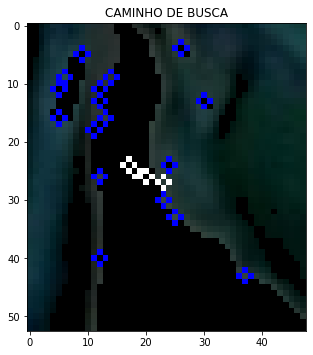

In [22]:
for item in caminhoPontos:
    
    x,y = item[0], item[1]
    
    cv.circle(imgSegBGR, (x,y), 1, (255,255,255))

mostraImagem(imgSegBGR, "CAMINHO DE BUSCA")

In [23]:
acuracia = pixel - pend
print(acuracia)

[29 25 20]


## Imagem de saída com o ponto encontrado

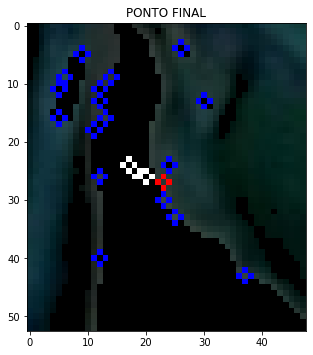

In [24]:
cv.circle(imgSegBGR, (pontoX,pontoY), 1, (255,0,0))

mostraImagem(imgSegBGR, "PONTO FINAL")

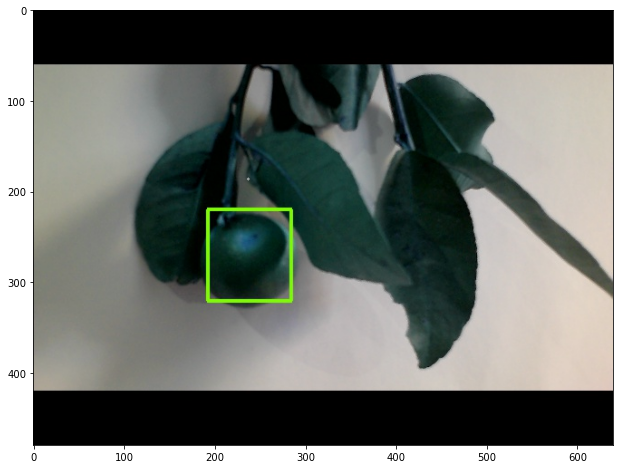

In [25]:
img = cv.imread(IMAGEM_CAPTURADA_NORMAL)

PontoFinalX = TopLeftX + pontoX
PontoFinalY = TopLeftY + pontoY

cv.circle(img, (PontoFinalX, PontoFinalY), 1, (255,255,255))

cv.imwrite("pedunculoEncontradoAritimetica" + idImagem + ".jpg", img)

fig = plt.figure(figsize = (20,8))
plt.imshow(img)
plt.show()

In [26]:
print("Coordenada de partida x,y: {}".format(pontoPartida))
print("A quantidade de busca foram: {}".format(contaBuscas))
print("O tempo de busca foi: {}".format(tempo))
print("As coordenadas pedunculo foram x,y: ({},{})".format(pontoX, pontoY))
print("As coordenadas finais são: x,y: ({},{})".format(PontoFinalX, PontoFinalY))

Coordenada de partida x,y: (17, 23)
A quantidade de busca foram: 4
O tempo de busca foi: 0.001531362533569336
As coordenadas pedunculo foram x,y: (23,27)
As coordenadas finais são: x,y: (237,186)
